# 1) A Position-Free Paradigm

In [2]:
import gurobipy as gp
from gurobipy import GRB

# Dados do contêiner
L, W, H = 12, 8, 8
Xo, Yo, Zo = 0, 0, 0
M = 50  # Número grande o suficiente

# Dados das caixas (li, wi, hi)
boxes = [
    (6, 3, 2), (6, 3, 2),              # caixas 1-2
    (6, 4, 3), (6, 4, 3), (6, 4, 3),   # caixas 3-7
    (6, 4, 3), (6, 4, 3),
    (8, 3, 2), (8, 3, 2), (8, 3, 2),   # caixas 8-10
    (4, 3, 2), (4, 3, 2),              # caixas 11-12
    (4, 4, 3), (4, 4, 3), (4, 4, 3)    # caixas 13-15
]

m = len(boxes)
vi = [(l * w * h) / (L * W * H) for l, w, h in boxes]

model = gp.Model("container_loading")

# Variáveis
p = model.addVars(m, vtype=GRB.BINARY, name="p")
x = model.addVars(m, vtype=GRB.CONTINUOUS, lb=0, name="x")
y = model.addVars(m, vtype=GRB.CONTINUOUS, lb=0, name="y")
z = model.addVars(m, vtype=GRB.CONTINUOUS, lb=0, name="z")

a = model.addVars(m, m, vtype=GRB.BINARY, name="a")
b = model.addVars(m, m, vtype=GRB.BINARY, name="b")
c = model.addVars(m, m, vtype=GRB.BINARY, name="c")
d = model.addVars(m, m, vtype=GRB.BINARY, name="d")
e = model.addVars(m, m, vtype=GRB.BINARY, name="e")
f = model.addVars(m, m, vtype=GRB.BINARY, name="f")

# Função objetivo
model.setObjective(gp.quicksum(vi[i] * p[i] for i in range(m)), GRB.MAXIMIZE)

# Restrições
for i in range(m):
    li, wi, hi = boxes[i]

    # Manter as caixas dentro do contêiner
    model.addConstr(x[i] >= (Xo * p[i]))
    model.addConstr(y[i] >= (Yo * p[i]))
    model.addConstr(z[i] >= (Zo * p[i]))
    model.addConstr((x[i] + li) <= (Xo + L))
    model.addConstr((y[i] + wi) <= (Yo + W))
    model.addConstr((z[i] + hi) <= (Zo + H))

    for j in range(i + 1, m):
        lj, wj, hj = boxes[j]

        # Garantir não sobreposição
        model.addConstr((x[i] + li) <= (x[j] + (1 - a[i, j]) * M))
        model.addConstr((x[j] + lj) <= (x[i] + (1 - b[i, j]) * M))
        model.addConstr((y[i] + wi) <= (y[j] + (1 - c[i, j]) * M))
        model.addConstr((y[j] + wj) <= (y[i] + (1 - d[i, j]) * M))
        model.addConstr((z[i] + hi) <= (z[j] + (1 - e[i, j]) * M))
        model.addConstr((z[j] + hj) <= (z[i] + (1 - f[i, j]) * M))

        # Relação espacial por par
        model.addConstr(a[i, j] + b[i, j] + c[i, j] + d[i, j] + e[i, j] + f[i, j] >= p[i] + p[j] - 1)

# Rodar o modelo
model.setParam('TimeLimit', 15)
model.optimize()

# Criar mapeamento de tipos de caixa
tipo_dict = {}
tipo_counter = 1
for box in boxes:
    if box not in tipo_dict:
        tipo_dict[box] = tipo_counter
        tipo_counter += 1

# Imprimir saída no formato correto
print(f"{L} {W} {H}")  # primeira linha: dimensões do contêiner

for i in range(m):
    li, wi, hi = boxes[i]
    x_i = x[i].X if p[i].X > 0.5 else 0
    y_i = y[i].X if p[i].X > 0.5 else 0
    z_i = z[i].X if p[i].X > 0.5 else 0
    tipo = tipo_dict[boxes[i]]  # tipo real baseado nas dimensões
    cliente = 1
    print(f"{x_i} {y_i} {z_i} {li} {wi} {hi} {tipo} {cliente}")

with open('dados1.txt','w') as f:
    f.write(f"{L} {W} {H}\n")  # primeira linha: dimensões do contêiner
    for i in range(m):
        if p[i].X > 0.5:
            li, wi, hi = boxes[i]
            x_i, y_i, z_i = x[i].X, y[i].X, z[i].X
            tipo = tipo_dict[boxes[i]]  # tipo baseado nas dimensões
            cliente = 1
            f.write(f"{x_i} {y_i} {z_i} {li} {wi} {hi} {tipo} {cliente}\n")


Set parameter TimeLimit to value 15
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-6300U CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Non-default parameters:
TimeLimit  15

Optimize a model with 825 rows, 1410 columns and 2820 nonzeros
Model fingerprint: 0x345c732c
Variable types: 45 continuous, 1365 integer (1365 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [3e-02, 9e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 0.0468750
Presolve removed 138 rows and 768 columns
Presolve time: 0.05s
Presolved: 687 rows, 642 columns, 2538 nonzeros
Variable types: 45 continuous, 597 integer (597 binary)

Root relaxation: objective 1.000000e+00, 223 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |   

## 1.1) Visualization

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Dimensões do contêiner
L, W, H = 12, 8, 8

# Dados das caixas (li, wi, hi)
boxes = [
    (6, 3, 2), (6, 3, 2), (6, 4, 3), (6, 4, 3), (6, 4, 3),
    (6, 4, 3), (6, 4, 3), (8, 3, 2), (8, 3, 2), (8, 3, 2),
    (4, 3, 2), (4, 3, 2), (4, 4, 3), (4, 4, 3), (4, 4, 3)
]

# Lista de caixas carregadas com coordenadas (x,y,z) e dimensões
loaded_boxes = []
for i in range(len(boxes)):
    if p[i].X > 0.5:  # A caixa foi carregada
        li, wi, hi = boxes[i]
        xi, yi, zi = x[i].X, y[i].X, z[i].X
        tipo = boxes[i]   # usar dimensão como identificador de tipo
        cliente = 1
        loaded_boxes.append((xi, yi, zi, li, wi, hi, tipo, cliente))

# Função para desenhar uma caixa
def draw_box(ax, x, y, z, l, w, h, color, tipo=None):
    vertices = [
        [x, y, z],
        [x+l, y, z],
        [x+l, y+w, z],
        [x, y+w, z],
        [x, y, z+h],
        [x+l, y, z+h],
        [x+l, y+w, z+h],
        [x, y+w, z+h]
    ]
    faces = [
        [vertices[j] for j in [0,1,2,3]],
        [vertices[j] for j in [4,5,6,7]],
        [vertices[j] for j in [0,1,5,4]],
        [vertices[j] for j in [2,3,7,6]],
        [vertices[j] for j in [1,2,6,5]],
        [vertices[j] for j in [3,0,4,7]]
    ]
    ax.add_collection3d(Poly3DCollection(faces, facecolors=color, linewidths=1, edgecolors='k', alpha=0.7))
    if tipo is not None:
        ax.text(x+l/2, y+w/2, z+h/2, f"{l}x{w}x{h}", color='k', fontsize=10, ha='center', va='center')

# Cores diferentes para cada tipo de caixa (por dimensão)
unique_types = list({b[6] for b in loaded_boxes})
colors_list = plt.cm.tab10.colors  # 10 cores disponíveis
type_color_map = {tipo: colors_list[i % len(colors_list)] for i, tipo in enumerate(unique_types)}

# Plot 3D
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

# Desenha cada caixa
for xi, yi, zi, li, wi, hi, tipo, cliente in loaded_boxes:
    draw_box(ax, xi, yi, zi, li, wi, hi, type_color_map[tipo], tipo=tipo)

# Desenhar contêiner (arestas)
# Vértices do contêiner
verts = [
    [0, 0, 0],     # 0: canto inferior-frontal-esquerdo
    [L, 0, 0],     # 1: canto inferior-frontal-direito
    [L, W, 0],     # 2: canto inferior-traseiro-direito
    [0, W, 0],     # 3: canto inferior-traseiro-esquerdo
    [0, 0, H],     # 4: canto superior-frontal-esquerdo
    [L, 0, H],     # 5: canto superior-frontal-direito
    [L, W, H],     # 6: canto superior-traseiro-direito
    [0, W, H]      # 7: canto superior-traseiro-esquerdo
]

# Arestas do contêiner (pares de índices dos vértices)
edges = [
    (0,1), (1,2), (2,3), (3,0),  # arestas inferiores
    (4,5), (5,6), (6,7), (7,4),  # arestas superiores
    (0,4), (1,5), (2,6), (3,7)   # arestas verticais
]

# Desenha as arestas
for s, e in edges:
    ax.plot([verts[s][0], verts[e][0]],
            [verts[s][1], verts[e][1]],
            [verts[s][2], verts[e][2]], color='k')


# Limites e rótulos
ax.set_xlim(0,L)
ax.set_ylim(0,W)
ax.set_zlim(0,H)
ax.set_xlabel('Comprimento')
ax.set_ylabel('Largura')
ax.set_zlabel('Altura')
ax.set_title('Carregamento 3D do Contêiner')

plt.tight_layout()
plt.show()


# 2) A Grid-Based Position Paradigm

In [ ]:
import gurobipy as gp
from gurobipy import GRB

# Parâmetros do problema (exemplo)
L, W, H = 12, 8, 8  # dimensões do contêiner

# Tipos de caixas: (li, wi, hi) e quantidade disponível bi
boxes = [
    (6, 3, 2, 2),
    (6, 4, 3, 5),
    (8, 3, 2, 3),
    (4, 3, 2, 2),
    (4, 4, 3, 3)
]

# Calcular o valor v_i como o volume relativo de cada caixa
v = [ (l * w * h) / (L * W * H) for (l, w, h, bi) in boxes ]

m = len(boxes)

# Conjuntos possíveis de posições, seguindo os "normal patterns" (simplificação)
# para cada dimensão e cada tipo de caixa
X = [range(L - li + 1) for (li, _, _, _) in boxes]
Y = [range(W - wi + 1) for (_, wi, _, _) in boxes]
Z = [range(H - hi + 1) for (_, _, hi, _) in boxes]

# Criar modelo
model = gp.Model("GridBasedPosition")

# Variáveis binárias x[i,p,q,r]: 1 se a caixa i está na posição (p,q,r)
x = {}
for i in range(m):
    li, wi, hi, bi = boxes[i]
    for p in X[i]:
        for q in Y[i]:
            for r in Z[i]:
                x[i, p, q, r] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{p}_{q}_{r}")

model.update()

# Função objetivo: objetivo depende de vi
model.setObjective(
    gp.quicksum(
        v[i] * x[i, p, q, r]
        for i in range(m)
        for p in X[i]
        for q in Y[i]
        for r in Z[i]
    ), 
    GRB.MAXIMIZE
)

# Restrição 1: Não sobrepor caixas
# Para cada posição no contêiner, só pode haver no máximo 1 caixa cobrindo essa posição

for xp in range(L):
    for yq in range(W):
        for zr in range(H):
            # Soma das variáveis que cobrem o ponto (xp,yq,zr) ≤ 1
            covering_vars = []
            for i in range(m):
                li, wi, hi, bi = boxes[i]
                for p in X[i]:
                    for q in Y[i]:
                        for r in Z[i]:
                            if p <= xp < p + li and q <= yq < q + wi and r <= zr < r + hi:
                                covering_vars.append(x[i, p, q, r])
            if covering_vars:
                model.addConstr(gp.quicksum(covering_vars) <= 1)

# Restrição 2: Quantidade máxima de cada tipo de caixa
for i in range(m):
    li, wi, hi, bi = boxes[i]
    model.addConstr(
        gp.quicksum(x[i, p, q, r] for p in X[i] for q in Y[i] for r in Z[i]) <= bi
    )

model.optimize()

# Criar mapeamento de tipos de caixa (igual ao primeiro código)
tipo_dict = {}
tipo_counter = 1
for (li, wi, hi, bi) in boxes:
    dims = (li, wi, hi)
    if dims not in tipo_dict:
        tipo_dict[dims] = tipo_counter
        tipo_counter += 1

# Imprimir saída no mesmo formato do primeiro
print(f"{L} {W} {H}")

with open("dados2.txt", "w") as f:
    f.write(f"{L} {W} {H}\n")

    for i in range(m):
        li, wi, hi, bi = boxes[i]
        for p in X[i]:
            for q in Y[i]:
                for r in Z[i]:
                    if x[i, p, q, r].X > 0.5:
                        tipo = tipo_dict[(li, wi, hi)]
                        cliente = 1
                        # Saída no formato padrão
                        print(f"{p} {q} {r} {li} {wi} {hi} {tipo} {cliente}")
                        f.write(f"{p} {q} {r} {li} {wi} {hi} {tipo} {cliente}\n")



Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-6300U CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 773 rows, 1362 columns and 59178 nonzeros
Model fingerprint: 0x87a17898
Variable types: 0 continuous, 1362 integer (1362 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 9e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 0.8125000
Presolve removed 720 rows and 1252 columns
Presolve time: 0.07s
Presolved: 53 rows, 110 columns, 494 nonzeros
Found heuristic solution: objective 0.4375000
Variable types: 0 continuous, 110 integer (110 binary)

Root relaxation: objective 9.296875e-01, 167 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dep

## 2.1) Visualization

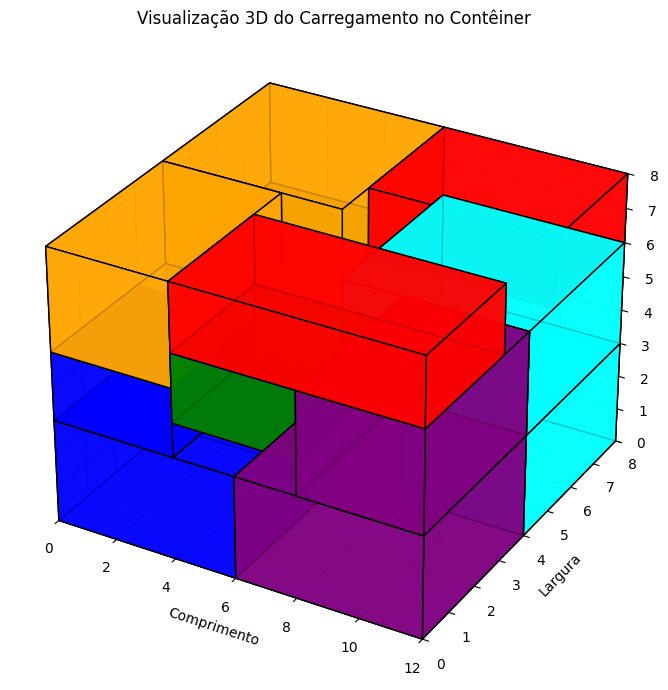

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Suponha que essas caixas foram carregadas, com as posições correspondentes
loaded_boxes = []
for (i, p, q, r), var in x.items():
    if var.X > 0.5:
        li, wi, hi, _ = boxes[i]
        loaded_boxes.append((p, q, r, li, wi, hi))

# Função para adicionar uma caixa à cena
def draw_box(ax, x, y, z, l, w, h, color):
    vertices = [
        [x, y, z],
        [x + l, y, z],
        [x + l, y + w, z],
        [x, y + w, z],
        [x, y, z + h],
        [x + l, y, z + h],
        [x + l, y + w, z + h],
        [x, y + w, z + h]
    ]
    faces = [
        [vertices[j] for j in [0,1,2,3]],
        [vertices[j] for j in [4,5,6,7]],
        [vertices[j] for j in [0,1,5,4]],
        [vertices[j] for j in [2,3,7,6]],
        [vertices[j] for j in [1,2,6,5]],
        [vertices[j] for j in [3,0,4,7]]
    ]
    ax.add_collection3d(Poly3DCollection(faces, facecolors=color, linewidths=1, edgecolors='k', alpha=0.8))

# Plotar
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Desenhar cada caixa carregada
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'yellow']
for i, (x, y, z, l, w, h) in enumerate(loaded_boxes):
    draw_box(ax, x, y, z, l, w, h, colors[i % len(colors)])

# Configurar limites e rótulos
ax.set_xlim(0, L)
ax.set_ylim(0, W)
ax.set_zlim(0, H)
ax.set_xlabel('Comprimento')
ax.set_ylabel('Largura')
ax.set_zlabel('Altura')
ax.set_title('Visualização 3D do Carregamento no Contêiner')

plt.tight_layout()
plt.show()


# 3) Vertical and Horizontal Stability Constraints

In [18]:
# Parâmetros do problema
L, W, H = 12, 8, 8  # dimensões do contêiner

# Caixas: (li, wi, hi, bi)
boxes = [
    (6, 3, 2, 2),
    (6, 4, 3, 5),
    (8, 3, 2, 3),
    (4, 3, 2, 2),
    (4, 4, 3, 3)
]

# Calcular o valor v_i como o volume relativo de cada caixa
v = [ (l * w * h) / (L * W * H) for (l, w, h, bi) in boxes ]

m = len(boxes)

# Conjuntos possíveis de posições (grid-based)
X = [range(L - li + 1) for (li, _, _, _) in boxes]
Y = [range(W - wi + 1) for (_, wi, _, _) in boxes]
Z = [range(H - hi + 1) for (_, _, hi, _) in boxes]

# Modelo
model = gp.Model("GridBasedPosition with vertical and horizontal stability constraints")

# Variáveis binárias x[i,p,q,r]
x = {}
for i in range(m):
    li, wi, hi, bi = boxes[i]
    for p in X[i]:
        for q in Y[i]:
            for r in Z[i]:
                x[i, p, q, r] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_{p}_{q}_{r}")

model.update()

# Função objetivo: maximizar volume relativo carregado
model.setObjective(
    gp.quicksum(
        v[i] * x[i, p, q, r]
        for i, (li, wi, hi, bi) in enumerate(boxes)
        for p in X[i]
        for q in Y[i]
        for r in Z[i]
    ),
    GRB.MAXIMIZE
)

# Restrição 1: Não sobrepor caixas
for xp in range(L):
    for yq in range(W):
        for zr in range(H):
            covering_vars = []
            for i, (li, wi, hi, bi) in enumerate(boxes):
                for p in X[i]:
                    for q in Y[i]:
                        for r in Z[i]:
                            if p <= xp < p + li and q <= yq < q + wi and r <= zr < r + hi:
                                covering_vars.append(x[i, p, q, r])
            if covering_vars:
                model.addConstr(gp.quicksum(covering_vars) <= 1)

# Restrição 2: Quantidade máxima de cada tipo de caixa
for i, (li, wi, hi, bi) in enumerate(boxes):
    model.addConstr(
        gp.quicksum(x[i, p, q, r] for p in X[i] for q in Y[i] for r in Z[i]) <= bi
    )

# ---------- Pré-computações: suportes possíveis com interseção positiva ----------
# Vamos criar três dicionários que, para cada (i,p,q,r), guardam tuplas (j,p0,q0,r0, overlap_area)
#  - vertical: r0 + hj == r  (j está imediatamente abaixo de i)
#  - horiz_x: p0 + lj == p   (j está imediatamente à esquerda de i)
#  - horiz_y: q0 + wj == q   (j está imediatamente "atrás" de i no eixo y)
supports_vertical = {}   # key = (i,p,q,r) -> list of (j,p0,q0,r0, area_overlap)
supports_horiz_x = {}    # key = (i,p,q,r) -> list of (j,p0,q0,r0, area_overlap) area = overlap_y * overlap_z
supports_horiz_y = {}    # key = (i,p,q,r) -> list of (j,p0,q0,r0, area_overlap) area = overlap_x * overlap_z

for i, (li, wi, hi, bi) in enumerate(boxes):
    for p in X[i]:
        for q in Y[i]:
            for r in Z[i]:
                # Vertical supports (floor handled later)
                sv = []
                for j, (lj, wj, hj, bj) in enumerate(boxes):
                    # procura r0 tal que r0 + hj == r (top face of j == bottom face of i)
                    r0 = r - hj
                    if r0 < 0:
                        continue
                    if r0 not in Z[j]:
                        continue
                    # percorrer p0,q0 possíveis de j mas só se houver overlap em xy
                    for p0 in X[j]:
                        Lij = min(p + li, p0 + lj) - max(p, p0)
                        if Lij <= 0:
                            continue
                        for q0 in Y[j]:
                            Wij = min(q + wi, q0 + wj) - max(q, q0)
                            if Wij <= 0:
                                continue
                            area = Lij * Wij
                            sv.append((j, p0, q0, r0, area))
                if sv:
                    supports_vertical[(i, p, q, r)] = sv

                # Horizontal X supports (j's right face at p: p0 + lj == p)
                shx = []
                for j, (lj, wj, hj, bj) in enumerate(boxes):
                    p0 = p - lj
                    if p0 < 0:
                        continue
                    if p0 not in X[j]:
                        continue
                    for q0 in Y[j]:
                        Wij = min(q + wi, q0 + wj) - max(q, q0)
                        if Wij <= 0:
                            continue
                        for r0 in Z[j]:
                            Hij = min(r + hi, r0 + hj) - max(r, r0)
                            if Hij <= 0:
                                continue
                            area = Wij * Hij  # overlap em Y * overlap em Z
                            shx.append((j, p0, q0, r0, area))
                if shx:
                    supports_horiz_x[(i, p, q, r)] = shx

                # Horizontal Y supports (j's back face at q: q0 + wj == q)
                shy = []
                for j, (lj, wj, hj, bj) in enumerate(boxes):
                    q0 = q - wj
                    if q0 < 0:
                        continue
                    if q0 not in Y[j]:
                        continue
                    for p0 in X[j]:
                        Lij = min(p + li, p0 + lj) - max(p, p0)
                        if Lij <= 0:
                            continue
                        for r0 in Z[j]:
                            Hij = min(r + hi, r0 + hj) - max(r, r0)
                            if Hij <= 0:
                                continue
                            area = Lij * Hij  # overlap em X * overlap em Z
                            shy.append((j, p0, q0, r0, area))
                if shy:
                    supports_horiz_y[(i, p, q, r)] = shy

# ---------- Vertical stability constraints (área de suporte >= área da base) ----------
# Inclui suporte do chão para caixas com r==0
for i in range(m):
    li, wi, hi, bi = boxes[i]
    for p in X[i]:
        for q in Y[i]:
            for r in Z[i]:
                sv = supports_vertical.get((i, p, q, r), [])

                # Se estiver no chão, adiciona suporte do chão
                if r == 0:
                    sv.append((-1, p, q, r, li * wi))  # -1 indica chão

                if sv:
                    expr = gp.quicksum(
                        (x[j, p0, q0, r0] if j != -1 else 1) * area
                        for (j, p0, q0, r0, area) in sv
                    )
                    model.addConstr(expr >= (li * wi) * x[i, p, q, r], name=f"vert_area_{i}_{p}_{q}_{r}")
                else:
                    # Sem suporte (nem chão nem outra caixa), proíbe a posição
                    model.addConstr(x[i, p, q, r] == 0)



# Para caixas com r==0 você já tem suporte pelo chão; se quiser modelar explicitamente:
# (opcional) model.addConstr(li*wi * x[i,p,q,0] <= li*wi)  # trivial

# ---------- Horizontal stability X (faces laterais) ----------
for key, shx in supports_horiz_x.items():
    i, p, q, r = key
    li, wi, hi, bi = boxes[i]
    # se p == 0 ou p+li == L então encostada na parede e estável horizontalmente
    if p == 0 or (p + li == L):
        continue
    expr = gp.quicksum(area * x[j, p0, q0, r0] for (j, p0, q0, r0, area) in shx)
    # área necessária para suportar na face lateral esquerda é li * hi
    model.addConstr(expr >= (li * hi) * x[i, p, q, r], name=f"horizX_area_{i}_{p}_{q}_{r}")

# ---------- Horizontal stability Y (faces front/back) ----------
for key, shy in supports_horiz_y.items():
    i, p, q, r = key
    li, wi, hi, bi = boxes[i]
    if q == 0 or (q + wi == W):
        continue
    expr = gp.quicksum(area * x[j, p0, q0, r0] for (j, p0, q0, r0, area) in shy)
    # área necessária para suportar na face frontal é wi * hi
    model.addConstr(expr >= (wi * hi) * x[i, p, q, r], name=f"horizY_area_{i}_{p}_{q}_{r}")


model.optimize()


# Criar mapeamento de tipos de caixa (igual ao primeiro código)
tipo_dict = {}
tipo_counter = 1
for (li, wi, hi, bi) in boxes:
    dims = (li, wi, hi)
    if dims not in tipo_dict:
        tipo_dict[dims] = tipo_counter
        tipo_counter += 1

# Imprimir saída no mesmo formato do primeiro
print(f"{L} {W} {H}")

with open("dados3.txt", "w") as f:
    f.write(f"{L} {W} {H}\n")

    for i in range(m):
        li, wi, hi, bi = boxes[i]
        for p in X[i]:
            for q in Y[i]:
                for r in Z[i]:
                    if x[i, p, q, r].X > 0.5:
                        tipo = tipo_dict[(li, wi, hi)]
                        cliente = 1
                        # Saída no formato padrão
                        print(f"{p} {q} {r} {li} {wi} {hi} {tipo} {cliente}")
                        f.write(f"{p} {q} {r} {li} {wi} {hi} {tipo} {cliente}\n")

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-6300U CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 2957 rows, 1362 columns and 217480 nonzeros
Model fingerprint: 0x26e64774
Variable types: 0 continuous, 1362 integer (1362 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [3e-02, 9e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 0.6875000
Presolve removed 998 rows and 285 columns
Presolve time: 3.02s
Presolved: 1959 rows, 1077 columns, 137772 nonzeros
Variable types: 0 continuous, 1077 integer (1077 binary)

Root relaxation: objective 9.140625e-01, 1302 iterations, 0.30 seconds (0.22 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Ga

## 3.1) Visualization

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Caixas carregadas na solução
loaded_boxes = []
for (i, p, q, r), var in x.items():
    if var.X > 0.5:  # A caixa foi escolhida
        li, wi, hi, _ = boxes[i]  # ignora o bi
        loaded_boxes.append((p, q, r, li, wi, hi))

# Função para desenhar cada caixa
def draw_box(ax, x, y, z, l, w, h, color):
    vertices = [
        [x, y, z],
        [x + l, y, z],
        [x + l, y + w, z],
        [x, y + w, z],
        [x, y, z + h],
        [x + l, y, z + h],
        [x + l, y + w, z + h],
        [x, y + w, z + h]
    ]
    faces = [
        [vertices[j] for j in [0,1,2,3]],
        [vertices[j] for j in [4,5,6,7]],
        [vertices[j] for j in [0,1,5,4]],
        [vertices[j] for j in [2,3,7,6]],
        [vertices[j] for j in [1,2,6,5]],
        [vertices[j] for j in [3,0,4,7]]
    ]
    ax.add_collection3d(Poly3DCollection(faces, facecolors=color, linewidths=1, edgecolors='k', alpha=0.8))

# Plotar
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Cores para diferenciar caixas
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'yellow']
for i, (x, y, z, l, w, h) in enumerate(loaded_boxes):
    draw_box(ax, x, y, z, l, w, h, colors[i % len(colors)])

# Configurações do gráfico
ax.set_xlim(0, L)
ax.set_ylim(0, W)
ax.set_zlim(0, H)
ax.set_xlabel('Comprimento')
ax.set_ylabel('Largura')
ax.set_zlabel('Altura')
ax.set_title('Visualização 3D do Carregamento no Contêiner')

plt.tight_layout()
plt.show()
